<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"></ul></div>

In [174]:
from ipywidgets import IntProgress
from IPython.display import display,HTML,clear_output
import random
import time
import math
import copy as cp
from math import radians, sin, cos, sqrt
import ROOT
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as widgets
from uits3_krakow22.src.Event import Event
from uits3_krakow22.src.Cluster import Cluster
from uits3_krakow22.src.Track import Track
from uits3_krakow22.src.Vertex import Vertex
from uits3_krakow22.src.Utils import *
from skspatial.plotting import plot_3d
from skspatial.objects import Points, Cylinder, Plane
from IPython.display import Image

display(HTML("<style>.container { width:95% !important; }</style>"))
display(HTML("<style>table {float:left;}</style>"))

In [175]:
maxi=0
mini=0
for i in range(1000):
    num=(random.random()-0.5)*10
    if num < mini:
        mini = num
    if num > maxi:
        maxi = num
print(mini, maxi)

-4.987968393614254 4.987126647950327


In [176]:
class Fiber:
    def __init__(self,center=[0,0,0],radius=0.075,height=10):
        self.center = center
        self.radius = radius
        self.height = height
        
    def getRandomPoint(self):
        R = random.random()*self.radius
        this_height = (random.random()-0.5)*self.height
        theta = random.random()*2*math.pi
        coordinate = [self.center[0]+R*math.cos(theta),this_height,self.center[2]+R*math.sin(theta)]
        return coordinate
    
class ALPIDECylinder:
    def __init__(self, p1, p2, radius):
        self.p1 = np.array(p1)
        self.p2 = np.array(p2)
        self.radius = radius
        self.center = (self.p1 + self.p2) / 2
        


[[0, 0, -16.83], [0, 0, -18.562050807568877], [-0.25, 0, -18.129038105676656], [0.25, 0, -18.129038105676656], [-0.5, 0, -17.696025403784436], [0, 0, -17.696025403784436], [0.5, 0, -17.696025403784436], [-0.75, 0, -17.26301270189222], [-0.25, 0, -17.26301270189222], [0.25, 0, -17.26301270189222], [0.75, 0, -17.26301270189222]]


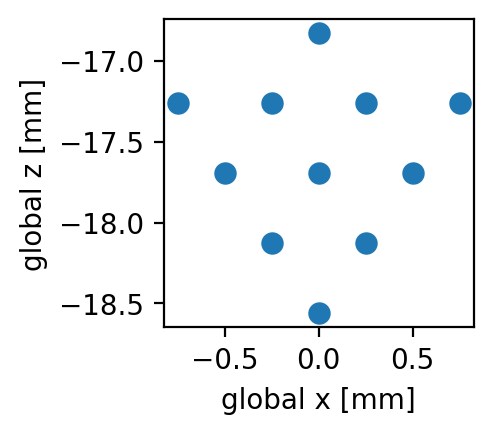

In [177]:
dist = 0.5 #spacing between fibers
#define arrays of coordinates for the center of each fiber
origin = [[0,0,0]] 
row1 = [[0,0,-2*dist*math.sqrt(3)]]
row2 = [[-dist*0.5,0,-dist*(3*math.sqrt(3)/2)],[dist*0.5,0,-dist*(3*math.sqrt(3)/2)]]
row3 = [[-dist,0,-dist*math.sqrt(3)],[0,0,-dist*math.sqrt(3)],[dist,0,-dist*math.sqrt(3)]]
row4 = [[-dist*1.5,0,-dist*math.sqrt(3)/2],[-dist*0.5,0,-dist*math.sqrt(3)/2],[dist*0.5,0,-dist*math.sqrt(3)/2],[dist*1.5,0,-dist*math.sqrt(3)/2]]
centers = origin + row1 + row2 + row3 + row4

for center in centers:
    center[2] = center[2]-16.83
print(centers)

fig = plt.figure(figsize=(2, 2), dpi=200)
ax = fig.add_subplot(111)
ax.set_xlabel("global x [mm]")
ax.set_ylabel("global z [mm]")
points = Points([[center[0],center[2]] for center in centers])
#plane = Plane.from_points(points[0],points[1],points[2])
#plane.plot_3d(ax, alpha=0.2)
points.plot_2d(ax, s=50)

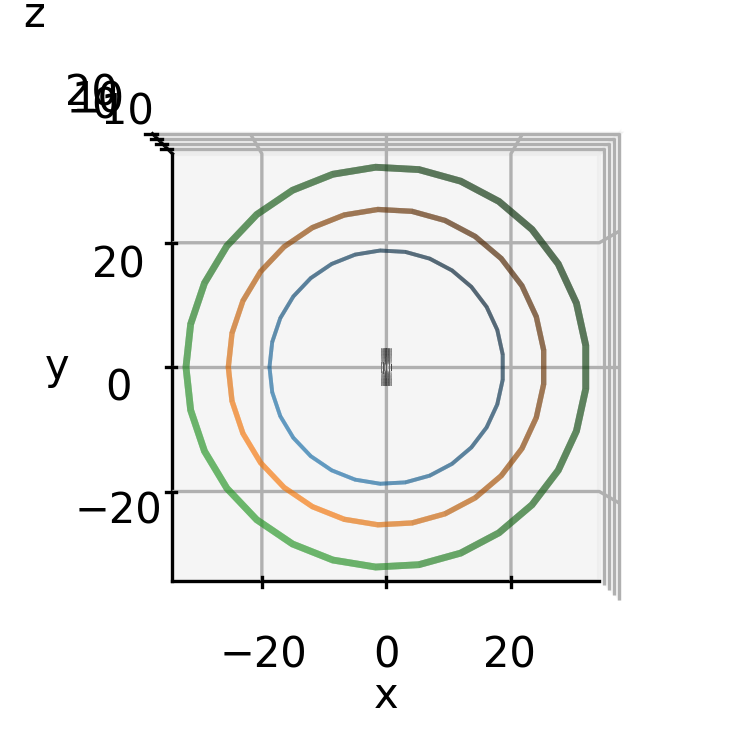

In [164]:
save = False
cylinders = [Cylinder([center[0],-3,center[2]],[0,+6,0],0.075) for center in centers] #defines the fibers
fig = plt.figure(figsize=(3, 3), dpi=300)
ax = fig.add_subplot(111, projection='3d')
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_zlabel("z")
#ax.set_proj_type('ortho')
#ax.view_init(-75,30,60)
ax.view_init(90,0,90)
for target in cylinders: #each target fiber is added
    target.plot_3d(ax,color="grey",alpha=1)
    
ALPIDE_0 = Cylinder([0,0,12.5-7.5], [0,0,15], 30)
ALPIDE_1 = Cylinder([0,0,6.25-7.5], [0,0,15], 24)
ALPIDE_2 = Cylinder([0,0,0-7.5], [0,0,15], 18)

ALPIDE_2.plot_3d(ax, alpha=1)
ALPIDE_1.plot_3d(ax, alpha=1)
ALPIDE_0.plot_3d(ax, alpha=1)

viewingAngles = [[0,0],[0,-90],[90,-90],[30,-55]]
if save:
    for [angle1,angle2] in viewingAngles:
        ax.view_init(angle1, angle2)
        plt.savefig("targets"+str(angle1)+"_"+str(angle2)+".png",bbox_inches='tight')

# Calculate Scattering Angle

In [165]:
print(math.log(100,10))

2.0


In [166]:
def calc_scat_angle_radians(L,LR,p,beta, Z):
    theta = (14.1 / (p*beta)) * math.sqrt(L / LR) * (1 + 1/9 * math.log(L/LR,10))
    #theta = (14.1 / Energy * math.sqrt(L / LR) * (1 + 1/9 * math.log(L/LR,10))
    return theta
radLength_Si = 9.370*(10**-2) #9.370cm
radLength_PolyPropylene =  49.47 *(10**-2) #21.35cm
radLength_Air=   3.039 *10**2 # 36.62 cm
#radiation length found from https://pdg.lbl.gov/2017/AtomicNuclearProperties/

air_path_length= 0.03 #try 10cm (3in) to start
detector_thickness=  50*(10**-6) # 50 um (25um was the "active layer")
fiber_thickness=100*(10**-6) #150um (is this radius?) Divide by two since half the protons have their first collision halfway through the target? If this is a valid assumption
                             #Roman suggeseted to use the radius indeed but berkin suggests trying 100 um so i do that
Energy =100
#p=647.025
#beta=0.567698
p=446.28 #for 100MeV
beta=0.429529
print(calc_scat_angle_radians(detector_thickness, radLength_Si, p, beta, 1)*1000, 'mrad for Si in ALPIDE for', Energy*2, 'MeV')
print(calc_scat_angle_radians(fiber_thickness, radLength_PolyPropylene, p, beta, 1)*1000, 'mrad for Polypropylene for',Energy*2, 'MeV')
print(calc_scat_angle_radians(air_path_length, radLength_Air, p, beta, 1)*1000, 'mrad for Air for',Energy*2, 'MeV and', air_path_length*100, 'cm')


1.0812759671191985 mrad for Si in ALPIDE for 200 MeV
0.6165169088125578 mrad for Polypropylene for 200 MeV
0.40555939434508637 mrad for Air for 200 MeV and 3.0 cm


In [167]:
openingAngle = (87.08/360)*2*math.pi #200MeV
#fiber = Fiber(center=[0,0,18.75],height=6,radius=0.075)
fibers = [Fiber(center=center,height=6,radius=0.075) for center in centers]
events = []
reps = 1#000
for i in range(reps):
    fiber = random.choice(fibers)
    phi = (random.random()-0.5)*math.pi * 0.265258238 #Berkin says this is the "wobble DoF"
    theta = openingAngle/2
    shift = (random.random()-0.5)*0.3
    
    origin = fiber.getRandomPoint()
    #origin = [0,-18.75,0]
    trackLeft = Track(point= origin,
                      vector=[math.sin(phi+shift)*math.cos(theta), math.cos(phi+shift), math.sin(phi+shift)*math.sin(theta)])
    #trackLeftScattered = trackLeft.get
    trackRight = Track(point=origin,
                      vector=[math.sin(-phi+shift)*math.cos(theta), math.cos(-phi+shift), math.sin(-phi+shift)*math.sin(theta)])
    event = Event(tracks=[trackLeft,trackRight])
    events.append(event)
    print(trackLeft.point, trackLeft.vector)
    print(trackRight.point, trackRight.vector)

[0.239140580683613, -1.4180346920153681, -18.13005611766924] [-0.3297232951094394, 0.8905642410594979, -0.313333498381986]
[0.239140580683613, -1.4180346920153681, -18.13005611766924] [0.1996751784793201, 0.9613141238215719, 0.18974977849898872]


# Calculate Expected DCA and Track RMS

## Intersection Calculations

In [168]:
def intersects_cylinder(cylinder, p1, p2, ignore): #cylinder can be defined along different axis i guess
    radius = cylinder.radius
    
    # Extract coordinates of the two points
    x1, y1, z1 = p1
    x2, y2, z2 = p2
    
    # Direction vector of the line
    direction = np.array([x2 - x1, y2 - y1, z2 - z1])
    dot_direction=cp.deepcopy(direction)
    # Vector from the cylinder center to the starting point of the line
    fibBool= False
    dim=0
    if radius > 1: #cylinder.center[0]==0 and cylinder.center[1]==0: #ALPIDE
        start_to_center = np.array([x1, y1, 0])# assumes the cylinder is centered along the z axis at 0. for a fiber, the cylinder is centered along a translation from the y axis
        #print(start_to_center)
        dot_direction[2]=0

        
    elif radius == 0.075: #cylinder.center[1]==0: #Fiber
        start_to_center = np.array([x1-cylinder.center[0], 0, z1-cylinder.center[2]])
        fibBool= True
        dot_direction[1]=0
    else:
        Print("Intersection error, not y or z axis")
    
    # Calculate the coefficients for the quadratic equation
    a = np.dot(dot_direction, dot_direction)
    b = 2 * np.dot(start_to_center, dot_direction)
    c = np.dot(start_to_center, start_to_center) - radius**2
    
    # Solve the quadratic equation
    discriminant = b**2 - 4*a*c
    if discriminant < 0:
        if fibBool == False:
            print("0 discriminant")
        return []  # No intersection    
    
    t1 = (-b + np.sqrt(discriminant)) / (2 * a)
    t2 = (-b - np.sqrt(discriminant)) / (2 * a)
    
    # Calculate intersection points
    intersection1 = list(np.array([x1, y1, z1]) + t1 * direction)
    intersection2 = list(np.array([x1, y1, z1]) + t2 * direction)
    #if fibBool == False:
    #    print("Defined intersections ", intersection1,intersection2)
    
    # Check if the intersection points are within the height range of the cylinder
    intersections=[]
    inters=0
    
    if fibBool:
        if cylinder.p1[1] <= intersection1[1] <= cylinder.p2[1] and intersection1[2] > z1: #checks if the intersection is within the height axis
            intersections.append(intersection1)
            inters+=1
        if cylinder.p1[1] <= intersection2[1] <= cylinder.p2[1] and intersection2[2] > z1:
            intersections.append(intersection2)
            inters+=1
    else:
        #print("ALPIDE intersect. positions ", intersection1, intersection2)
        if (cylinder.p1[2] <= intersection1[2] <= cylinder.p2[2] or ignore):# and intersection1[2] > cylinder.center[2]:
            intersections.append(intersection1)
            inters+=1
            #print("This is the first statement ")
        if (cylinder.p1[2] <= intersection2[2] <= cylinder.p2[2] or ignore): # and intersection2[2] > cylinder.center[2]:
            intersections.append(intersection2)
            inters+=1
            #print("This is the second statement ")
            
    
    if inters == 2:
        #print("more than one intersection >-19", cylinder.center)
        #print("intersections 1", intersections)
        
        if(intersection1[2]<intersection2[2]): #chooses further forward scattered intersection
            intersections.remove(intersection1)
        else:
            intersections.remove(intersection2)
        #print("intersections 2", intersections)
    return intersections

#what does the code above do?
#it takes in a cylinder, a point, and a vector and returns the intersection points of the cylinder and the line defined by the point and vector (if any) 

In [169]:

# Check if the line intersects with the cylinder
def does_line_intersect_cylinder(point1, point2):
    # Calculate the parameters for the line equation (point-slope form)
    x1, y1, z1 = point1
    x2, y2, z2 = point2
    direction = np.array([x2 - x1, y2 - y1, z2 - z1])

    
    # Check the orientation of the cylinder based on its dimensions
    if cylinder_height == 0:
        # Cylinder centered on the z-axis
        #A = (x2 - x1)**2 + (y2 - y1)**2
        #B = 2 * ((x2 - x1) * (x1 - cylinder_center[0]) + (y2 - y1) * (y1 - cylinder_center[1]))
        #C = cylinder_equation_z_axis(x1, y1, z1) - cylinder_radius**2
        
        A = np.dot(direction[:2], direction[:2])
        B = 2 * np.dot(start_to_center[:2], direction[:2])
        C = np.dot(start_to_center[:2], start_to_center[:2]) - radius**2
    else:
        # Cylinder centered on the y-axis
        A = (x2 - x1)**2 + (z2 - z1)**2
        B = 2 * ((x2 - x1) * (x1 - cylinder_center[0]) + (z2 - z1) * (z1 - cylinder_center[2]))
        C = cylinder_equation_y_axis(x1, y1, z1) - cylinder_radius**2

    discriminant = B**2 - 4 * A * C

    if discriminant < 0:
        return False, None  # No intersection, no points
    else:
        t1 = (-B + np.sqrt(discriminant)) / (2 * A)
        t2 = (-B - np.sqrt(discriminant)) / (2 * A)

        intersection_point1 = point1 + t1 * (point2 - point1)
        intersection_point2 = point1 + t2 * (point2 - point1)

        return True, [intersection_point1, intersection_point2]


## Scattering and Rotation

In [170]:
def rotate_vector(vector, axis, angle):
    axis = axis / np.linalg.norm(axis)
    a = cos(angle / 2.0)
    b, c, d = -axis * sin(angle / 2.0)
    rotation_matrix = np.array([[a*a + b*b - c*c - d*d, 2*(b*c - a*d), 2*(b*d + a*c)],
                                [2*(b*c + a*d), a*a + c*c - b*b - d*d, 2*(c*d - a*b)],
                                [2*(b*d - a*c), 2*(c*d + a*b), a*a + d*d - b*b - c*c]])
    return np.dot(rotation_matrix, vector)


    # Calculate random scattering wit sigma from scattering_angle_radians
def scattering_angle_radians_random(scattering_angle_radians):
    return scattering_angle_radians * np.random.randn()

## Calculate change in vector slope

In [235]:
def perturb_ALPIDE_line_slope(line_coords, scattering_angle_radians, printing):
    # Extract coordinates
    #print("line_coords", line_coords)
    x, y, z, x2, y2, z2 = line_coords #represent point on target and point on ALPIDE 2
    
    # Calculate the original direction vector of the line from target to point on ALPIDE 2
    dx = x2 - x
    dy = y2 - y
    dz = z2 - z
    original_direction = np.array([dx, dy, dz])
    #intersection_points_ALPIDE_2 = intersects_cylinder(cALPIDE_2, line_coords[0:3],line_coords[3:6], False)   
    intersection_points_ALPIDE_2 = intersects_cylinder(cALPIDE_2, [x, y, z],[x2, y2, z2], False)   

    if not np.any(intersection_points_ALPIDE_2):
        if printing: 
            print('No ALPIDE 2 Intercept. intersection_points_ALPIDE_2 ', intersection_points_ALPIDE_2)
            print('line_coords ', line_coords)
        return 1    
    #print(intersection_points_ALPIDE_2)
    x2, y2, z2 = intersection_points_ALPIDE_2[0]


    # Calculate the initial intersection with ALPIDE1
    intersection_points_ALPIDE_1 = intersects_cylinder(cALPIDE_1, np.array([x, y, z]), np.array([x2, y2, z2]), False)

    if not np.any(intersection_points_ALPIDE_1):
        if printing: print('No ALPIDE 1 Intercept')
        return 1  
    x1, y1, z1 = intersection_points_ALPIDE_1[0]
   
    # Generate random azimuth angles for scattering off the first two ALPIDEs
    azimuth_ALPIDE2_radians = np.random.uniform(0, 2 * np.pi)
    azimuth_ALPIDE1_radians = np.random.uniform(0, 2 * np.pi)

    # Perturb the line slope between ALPIDE 2 and 1
    axis_ALPIDE2 = np.array([cos(azimuth_ALPIDE2_radians), sin(azimuth_ALPIDE2_radians), 0])
    #chose the random azimuth for the scattering angle
    perturbed_direction1 = rotate_vector(np.array([x1 - x2, y1 - y2, z1 - z2]), axis_ALPIDE2, scattering_angle_radians_random(scattering_angle_radians))

    # Calculate new 3D coordinates for the second point based on the perturbed direction
    # Might have to be added but i think this is the wrong sort of factor 
    x1_new = x1 + perturbed_direction1[0]
    y1_new = y1 + perturbed_direction1[1]
    z1_new = z1 + perturbed_direction1[2]

    intersection_points_ALPIDE_1 = intersects_cylinder(cALPIDE_1, np.array([x2, y2, z2]), np.array([x1_new, y1_new, z1_new]), False)
    
    if not np.any(intersection_points_ALPIDE_1):
        if printing: print('No ALPIDE 1 Intercept')
        return 1
    
    # Calculate the initial intersection with ALPIDE0 using vector from previous collision
    intersection_points_ALPIDE_0 = intersects_cylinder(cALPIDE_0, np.array([x2, y2, z2]), np.array([x1_new, y1_new, z1_new]), True) #this is the one that is wrong i think because it is not using the perturbed direction where it should be
    
    if not np.any(intersection_points_ALPIDE_0):
        if printing: print('First No ALPIDE 0 Intercept')
        return 1
    x0, y0, z0 = intersection_points_ALPIDE_0[0]
   
    # Perturb the line slope between ALPIDE 1 and 0
    axis_ALPIDE1 = np.array([cos(azimuth_ALPIDE1_radians), sin(azimuth_ALPIDE1_radians), 0])
    perturbed_direction0 = rotate_vector(np.array([x0 - x1, y0 - y1, z0 - z1]), axis_ALPIDE1, scattering_angle_radians_random(scattering_angle_radians))

    
    # Calculate new 3D coordinates for the second point based on the perturbed direction
    x0_new = x0 + perturbed_direction0[0]
    y0_new = y0 + perturbed_direction0[1]
    z0_new = z0 + perturbed_direction0[2]

    intersection_points_ALPIDE_0 = intersects_cylinder(cALPIDE_0,intersection_points_ALPIDE_1[0], np.array([x0_new, y0_new, z0_new]), True) #this is the one that is wrong i think because it is not using the perturbed direction where it should be
    
    if not np.any(intersection_points_ALPIDE_0):
        if printing: print('Second No ALPIDE 0 Intercept')
        return 1
    #index1 = 0
    #index2 = 0
    #if intersection_points_ALPIDE_1[0][2] < intersection_points_ALPIDE_1[1][2]:
    #    index1 = 1 #we want the positive intercept   
    #if intersection_points_ALPIDE_2[0][2] < intersection_points_ALPIDE_2[1][2]:
    #    index2 = 1
        
    return x2, y2, z2, *intersection_points_ALPIDE_1[0], *intersection_points_ALPIDE_0[0]

def perturb_Fiber_line_slope(line_coords, fiber, scattering_angle_radians): #fiber is the one getting hit
    # Extract coordinates
    x, y, z, x2, y2, z2 = line_coords #represent point on target and point on ALPIDE 2
    
    # Calculate the original direction vector of the line from target to point on ALPIDE 2
    dx = x2 - x
    dy = y2 - y
    dz = z2 - z
    original_direction = np.array([dx, dy, dz])
    intersection_points_fiber = intersects_cylinder(fiber, np.array(line_coords[0:3]),np.array(line_coords[3:6]), True) #here we want the point within the fiber
    #print(intersection_points_fiber)
    x1, y1, z1 = intersection_points_fiber[0]
   
    # Generate random azimuth angles for scattering
    azimuth = np.random.uniform(0, 2 * np.pi)

    # Perturb the line slope between fiber ALPIDE 2. do I have the coordinates right here?
    axis = np.array([cos(azimuth), sin(azimuth), 0])
    #chose the random azimuth for the scattering angle
    perturbed_direction = rotate_vector(np.array([dx, dy, dz]), axis, scattering_angle_radians_random(scattering_angle_radians))

    # Calculate new 3D coordinates for the second point based on the perturbed direction
    x2_new = x2 + perturbed_direction[0]
    y2_new = y2 + perturbed_direction[1]
    z2_new = z2 + perturbed_direction[2]
    #print(np.array([x1, y1, z1]), np.array([x2_new, y2_new, z2_new]))
    intersection_points = intersects_cylinder(cALPIDE_2, np.array([x1, y1, z1]), np.array([x2_new, y2_new, z2_new]), True)
    
    #print("Intersection points", intersection_points[0][2],intersection_points[1][2])
    #if (intersection_points[0][2] < intersection_points[1][2]):
    #    index = 1 #we want the positive intercept    
    x2_new, y2_new, z2_new = intersection_points[0]
    return x1, y1, z1, x2_new, y2_new, z2_new


In [172]:
def plot_cylinder(cylinder, ax, color, ALP):
    # Plot the cylinder as a vertical line between the two points p1 and p2
    #ax.plot([cylinder.p1[0], cylinder.p2[0]], [cylinder.p1[1], cylinder.p2[1]], [cylinder.p1[2], cylinder.p2[2]], color='blue')
    # Plot the circular top face of the cylinder
    if(ALP):
        t = np.linspace(0, 2*np.pi, 100)
        x_circle = cylinder.radius * np.cos(t) + cylinder.p1[0]
        y_circle = cylinder.radius * np.sin(t) + cylinder.p1[1]
        z_circle = np.full_like(t, cylinder.p1[2])
        ax.plot(x_circle, y_circle, z_circle, color=color,linewidth=1)
        # Plot the circular bottom face of the cylinder
        x_circle = cylinder.radius * np.cos(t) + cylinder.p2[0]
        y_circle = cylinder.radius * np.sin(t) + cylinder.p2[1]
        z_circle = np.full_like(t, cylinder.p2[2])
        ax.plot(x_circle, y_circle, z_circle, color=color,linewidth=1)
    else:
        t = np.linspace(0, 2*np.pi, 100)
        x_circle = cylinder.radius * np.cos(t) + cylinder.p1[0]
        y_circle = cylinder.radius * np.sin(t) + cylinder.p1[2]
        z_circle = np.full_like(t, cylinder.p1[1])
        ax.plot(x_circle, z_circle, y_circle, color=color,linewidth=1)
        # Plot the circular bottom face of the cylinder
        x_circle = cylinder.radius * np.cos(t) + cylinder.p2[0]
        y_circle = cylinder.radius * np.sin(t) + cylinder.p2[2]
        z_circle = np.full_like(t, cylinder.p2[1])
        ax.plot(x_circle, z_circle, y_circle, color=color,linewidth=1)

def plot_line(line_coords, ax, color):
    #print("linecoords ", line_coords)
    ax.plot([line_coords[0], line_coords[3]], [line_coords[1], line_coords[4]], [line_coords[2], line_coords[5]], color=color,linewidth=0.2)

In [214]:
moreColors = [
    'red',
    'green',
    'blue',
    'yellow',
    'magenta',
    'cyan',
    'violet',
    'black',
    'orange',
    'purple',
    'gray',
    'white'
]
cALPIDE_0 = ALPIDECylinder([0,0,12.5-7.5], [0,0,15], 30)
cALPIDE_1 = ALPIDECylinder([0,0,6.25-7.5], [0,0,15], 24)
cALPIDE_2 = ALPIDECylinder([0,0,0-7.5], [0,0,15], 18)
def furtherPoint(pointList):
    if len(pointList) == 0:
        return []
    elif  len(pointList) == 1:
        return pointList[0]
    elif(pointList[0][2] > pointList[1][2]):
        return pointList[0]
    else:
        return pointList[1]

both tracks hit done
both tracks hit done
both tracks hit done
both tracks hit done
both tracks hit done
both tracks hit done
both tracks hit done
both tracks hit done
both tracks hit done
both tracks hit done
both tracks hit done
both tracks hit done
both tracks hit done
both tracks hit done
both tracks hit done
both tracks hit done
both tracks hit done
both tracks hit done
both tracks hit done
both tracks hit done
both tracks hit done
both tracks hit done
both tracks hit done
both tracks hit done
both tracks hit done
both tracks hit done
both tracks hit done
both tracks hit done
both tracks hit done
both tracks hit done
both tracks hit done
both tracks hit done
both tracks hit done
both tracks hit done
both tracks hit done
both tracks hit done
both tracks hit done
both tracks hit done
both tracks hit done
both tracks hit done
both tracks hit done
both tracks hit done
both tracks hit done
both tracks hit done
both tracks hit done
both tracks hit done
both tracks hit done
both tracks h

<Figure size 640x480 with 0 Axes>

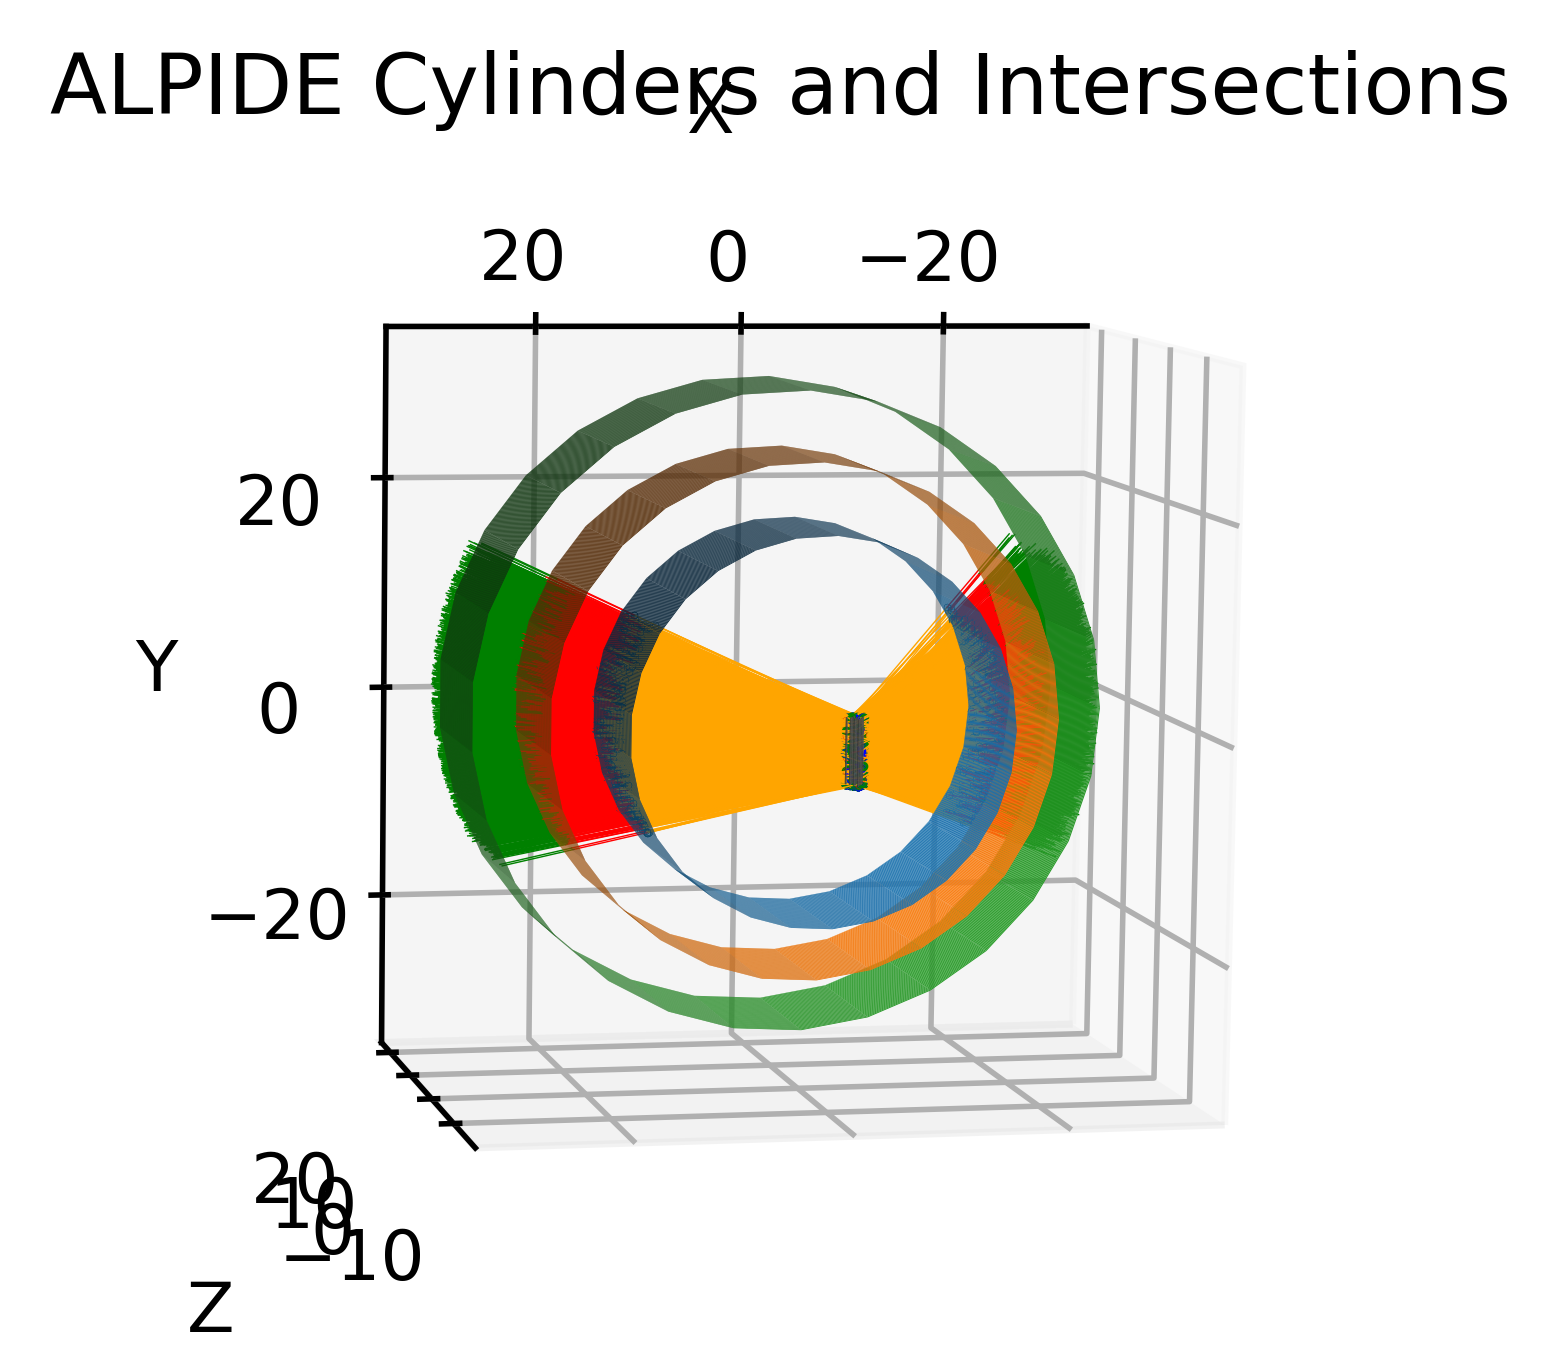

Warning in <TROOT::Append>: Replacing existing TH1: VertexXY (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: VertexXZ (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: VertexYZ (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: DCA cluster (Potential memory leak).


In [243]:
%jsroot on
hVertexXY = ROOT.TH2F("VertexXY","VertexXY",200,-7,7,200,-7,7)
hVertexXY.GetXaxis().SetTitle("Vertex X position [mm]")
hVertexXY.GetYaxis().SetTitle("Vertex Y position [mm]")
hVertexXZ = ROOT.TH2F("VertexXZ","VertexXZ",200,-5,5,200,-23,-15)
hVertexXZ.GetXaxis().SetTitle("Vertex X position [mm]")
hVertexXZ.GetYaxis().SetTitle("Vertex Z position [mm]")
hVertexYZ = ROOT.TH2F("VertexYZ","VertexYZ",200,-7,7,200,-26,-12)
hVertexYZ.GetXaxis().SetTitle("Vertex Y position [mm]")
hVertexYZ.GetYaxis().SetTitle("Vertex Z position [mm]")
hDCA = ROOT.TH1F("DCA cluster","DCA Cluster",22*10,-0.1,1000.1)
hDCA.GetXaxis().SetTitle("DCA [um]")
hDCA.GetYaxis().SetTitle("Count")

printing = False
# Create a 3D plot
fig = plt.figure()
save = False


fig = plt.figure(figsize=(3, 3), dpi=500)
ax = fig.add_subplot(111, projection='3d')
#ax.view_init(80,10,100)
#ax.view_init(0,90,90) #top down
#ax.set_zlim(-20,-16)
#ax.set_xlim(-2,2)

ax.view_init(90,0,90) #front view
#ax.view_init(-75,30,60) #nice angle
for target in cylinders: #each target fiber is added
    target.plot_3d(ax,color="grey",alpha=1)

ALPIDE_2.plot_3d(ax, alpha=1)
ALPIDE_1.plot_3d(ax, alpha=1)
ALPIDE_0.plot_3d(ax, alpha=1)

#scattering_angle_radians = 1.39/1000 #*10# Fixed scattering angle in radians   check with berkin that i should not divide by /2.355. but if thet0 is sigma then shouldnt it be *2/2.355? Check with berkin and try this next!
#fiber_scattering_angle_radians = 1.00/1000

scattering_angle_radians = 1.081/1000 #0.724/1000 *10 #*10# Fixed scattering angle in radians   check with berkin that i should not divide by /2.355. but if thet0 is sigma then shouldnt it be *2/2.355? Check with berkin and try this next!
fiber_scattering_angle_radians = 0.6165/1000 #0.78/1000 *10
#Have to start a loop here that generates reps number of left and right tracks, we only select events which pass through all ALPIDEs
#here a random origin is generated:
reps = 50000
numEvents=0
events=[]
dcaVals=[]
openingAngle = (87.08/360)*2*math.pi #200MeV
missed =0
fiberMultScatters = 0
for i in range(reps):
    percentage_done = (i / reps) * 100

    # Print the percentage completion
    print(f"Progress: {percentage_done:.2f}% done", end='\r')
    
    
    fiber = random.choice(fibers)
    phi = openingAngle/2
    shift = (random.random()-0.5)*0.3
    theta = (random.random()-0.5)*math.pi*0.265258238
    origin = fiber.getRandomPoint()
    ax.plot(origin[0],origin[1],origin[2], marker='.', markersize=0.1, color="red")
    
    leftVector=[math.sin(phi+shift)*math.cos(theta), math.sin(phi+shift)*math.sin(theta), math.cos(phi+shift)]
    rightVector=[math.sin(-phi+shift)*math.cos(theta), math.sin(-phi+shift)*math.sin(theta), math.cos(-phi+shift)]
    
    azimuth_left_radians = np.random.uniform(0, 2 * np.pi)
    azimuth_right_radians = np.random.uniform(0, 2 * np.pi)

    #should be generating a random azimuth
    axis_left = np.array([cos(azimuth_left_radians), sin(azimuth_left_radians), 0]) 
    axis_right = np.array([cos(azimuth_right_radians), sin(azimuth_right_radians), 0])
    


    scat_leftVector=rotate_vector(leftVector, axis_left, scattering_angle_radians_random(fiber_scattering_angle_radians))
    scat_rightVector=rotate_vector(rightVector, axis_right, scattering_angle_radians_random(fiber_scattering_angle_radians))
    scat_leftVectorArr=[]
    scat_rightVectorArr=[]
    for num in scat_leftVector: scat_leftVectorArr.append(num)
    for num in scat_rightVector: scat_rightVectorArr.append(num)

    #print(scat_leftVectorArr)
    trackLeft = Track(point=origin,vector=scat_leftVectorArr)
    trackRight = Track(point=origin,vector=scat_rightVectorArr)

    event = Event(tracks=[trackLeft,trackRight]) #this event may be useful to compare no scattering case with multiple scattering
    events.append(event) 

    line_coords_left = (*trackLeft.point, *furtherPoint(ALPIDE_2.intersect_line(trackLeft.line)))
    #print("first line_coords_left ", line_coords_left)
    line_coords_right = (*trackRight.point, *furtherPoint(ALPIDE_2.intersect_line(trackRight.line)))
    #print("second line_coords_right ", line_coords_right)
    #begin implementation of colisions with fibers--------------------------------------------------------------------------------------------------------------------
    
    for i,fib in enumerate(fibers): #problem, we must exclude collisions with the fibers behind the one that is started with
        #print("i, line_coords_left", i, line_coords_left)
        if(fib.center[2] > line_coords_left[2] or fib.center[2] > line_coords_right[2]):
            p1=cp.deepcopy(fib.center)
            p2=cp.deepcopy(fib.center)
            p1[1]= -3
            p2[1]= 3
            #print('P1, P2, center: ', p1, p2, fib.center)
            Afib = ALPIDECylinder(p1,p2,0.075)
            #plot_cylinder(Afib,ax,'blue',False)
            #print(intersects_cylinder(Afib, np.array(line_coords_left[0:3]),np.array(line_coords_left[3:6]))) 
            if(len(line_coords_left)==6):
                myIntersectionLeft = furtherPoint(intersects_cylinder(Afib, line_coords_left[0:3],line_coords_left[3:6], False))
            if(len(line_coords_right)==6):
                myIntersectionRight = furtherPoint(intersects_cylinder(Afib, line_coords_right[0:3],line_coords_right[3:6], False))
            if(len(myIntersectionLeft) == 3):
                #print("myIntersectionLeft", myIntersectionLeft)
                if(myIntersectionLeft[2] > fib.center[2]): #if left side intersects a fiber
                    #print("Line coords left= ", perturb_Fiber_line_slope(line_coords_left, Afib, fiber_scattering_angle_radians))
                    plot_coords = list(cp.deepcopy(line_coords_left[0:3]))#this is the origin
                    plot_coords+=myIntersectionLeft
                    ax.plot(plot_coords[0],plot_coords[1],plot_coords[2], marker='.', markersize=0.8, color="blue")  #origin
                    ax.plot(plot_coords[3],plot_coords[4],plot_coords[5], marker='.', markersize=0.8, color="green") #fiber hit
                    plot_line(plot_coords, ax, moreColors[i])
                    
                    #print("line_coords_left", line_coords_left)
                    line_coords_left = list(line_coords_left)
                    if(len(line_coords_left)!=6):
                        print("NO INTERSECTION ERROR len(line_coords_left)!=6 ", line_coords_left)
                    line_coords_left = list(perturb_Fiber_line_slope(line_coords_left, Afib, fiber_scattering_angle_radians))
                    #print("myIntersectionLeft[0], line_coords_left", myIntersectionLeft, line_coords_left)
                    #print("intersects_cylinder(cALPIDE_2, line_coords_left[0:3],line_coords_left[3:6], True)", intersects_cylinder(cALPIDE_2, line_coords_left[0:3],line_coords_left[3:6], True))
                    line_coords_left[3:6] = intersects_cylinder(cALPIDE_2, line_coords_left[0:3],line_coords_left[3:6], True)[0]
                    #print("line_coords_left[3:6]", line_coords_left[3:6]) #
                    #copilot, ^This line is whats breaking the code. this returns an empty array and i dont know why, it was working before!
    
                    #maybe the perturbed coordinate is broken i dont know. use Geant4 before this!

                    
                    line_coords_left[0:3] = myIntersectionLeft
                    fiberMultScatters+=1
                    #plot_line(line_coords_left, ax, 'brown')
                    #plot_coords+=line_coords_left[3:6] #these should be the coordinates that intersects with Afib
                    #print("Line coords left ", line_coords_left)
            if(len(myIntersectionRight) == 3):
                #print("myIntersectionRight", myIntersectionRight)
                if(myIntersectionRight[2] > fib.center[2]): #if right side intersects a fiber
                    plot_coords = list(cp.deepcopy(line_coords_right[0:3]))
                    plot_coords+=myIntersectionRight
                    ax.plot(plot_coords[0],plot_coords[1],plot_coords[2], marker='.', markersize=0.8, color="blue")
                    ax.plot(plot_coords[3],plot_coords[4],plot_coords[5], marker='.', markersize=0.8, color="green")
                    plot_line(plot_coords, ax, moreColors[i])
                    
                    line_coords_right = list(line_coords_right)
                    if(len(line_coords_right)!=6):
                        print("NO INTERSECTION ERROR len(line_coords_right)!=6 ", line_coords_right)
                    line_coords_right = list(perturb_Fiber_line_slope(line_coords_right, Afib, fiber_scattering_angle_radians))
                    line_coords_right[3:6] = intersects_cylinder(cALPIDE_2, line_coords_right[0:3],line_coords_right[3:6], True)[0]
                    line_coords_right[0:3] = myIntersectionRight #should be the coordinates that intersects with Afib
                    fiberMultScatters+=1
                    #print("Line coords right ", line_coords_right)
                


    #end implementation of colisions with fibers--------------------------------------------------------------------------------------------------------------------
    line_coords_left = list(line_coords_left)
    line_coords_right = list(line_coords_right)
    #if(len(line_coords_left)==6):
        #print("line_coords_left ", line_coords_left)
    new_line_coords_left = perturb_ALPIDE_line_slope(line_coords_left, scattering_angle_radians, printing)
    #if(len(line_coords_right)==6):
    #print("line_coords_right ", line_coords_right)
    new_line_coords_right = perturb_ALPIDE_line_slope(line_coords_right, scattering_angle_radians, printing)
    leftCoordBool = True
    rightCoordBool = True
    if new_line_coords_left == 1:
        if printing: 
            print('Missing left intersection')
            print("line_coords_left ", line_coords_left)
        leftCoordBool = False
    #    return 0
        missed+=1
    else:
        #print('Hit left intersection')
        #print("line_coords_left ", line_coords_left)
        xL,yL,zL = cp.deepcopy(new_line_coords_left[0:3]) #can we fix this so that the int can be subscribed to? #yes but it will be a lot of work #i dont think it will be that much
        x2, y2, z2 = cp.deepcopy(intersects_cylinder(cALPIDE_2, np.array(new_line_coords_left[0:3]),np.array(new_line_coords_left[3:6]), False)[0])
        if i%100: 
            plot_line(line_coords_left, ax, color = 'orange') #should be line from origin to ALPIDE2 left
            ax.plot(xL,yL,zL , marker='.', markersize=0.1, color="blue")
            ax.plot(x2, y2, z2 , marker='.', markersize=0.1, color="green")

    if new_line_coords_right == 1:
        if printing: 
            print('Missing right intersection')
            print("line_coords_right ", line_coords_right)
        rightCoordBool = False
        missed+=1
    else:
        #print('Hit right intersection')
        #print("line_coords_right ", line_coords_right)
        xR,yR,zR = cp.deepcopy(new_line_coords_right[0:3])
        x3, y3, z3 = cp.deepcopy(intersects_cylinder(cALPIDE_2, np.array(new_line_coords_right[0:3]),np.array(new_line_coords_right[3:6]), False)[0])      
        if i%100:               
            plot_line(line_coords_right, ax, color = 'orange')  
            ax.plot(xR,yR,zR , marker='.', markersize=0.1, color="blue")
            ax.plot(x3, y3, z3 , marker='.', markersize=0.1, color="green")

    if leftCoordBool and rightCoordBool:
        print("both tracks hit")
     #check this statement might be wrong needs to require both to be false before
        numEvents+=1 
        #copilot why are events that are scattered by fibers considered missed? #because they are not being plotted in the event viewer 
        #what can i do to fix this? #plot them in the event viewer
        #how do i do that? #i dont know but i think you can figure it out #i dont know how to plot them in the event viewer

        #x,y,z = line_coords_left[0:3]         
        #x2, y2, z2 = intersects_cylinder(cALPIDE_2, np.array(line_coords_left[0:3]),np.array(line_coords_left[3:6]), True)[0]
        #x3, y3, z3 = intersects_cylinder(cALPIDE_2, np.array(line_coords_right[0:3]),np.array(line_coords_right[3:6]), True)[0]  
        # Plot the line segments
        #print("[xL,yL,zL, x2, y2, z2]",[xL,yL,zL, x2, y2, z2],)
        #if(i%1==0):
         #   print("[*new_line_coords_left] ", [*new_line_coords_left])
          #  print("[*new_line_coords_right] ",[*new_line_coords_right])
             #should be line from origin to ALPIDE2 right
        #plot_line([xL,yL,zL, x2, y2, z2], ax, color = 'orange') #should be line from origin to ALPIDE2 left
        #plot_line([xR,yR,zR, x3, y3, z3], ax, color = 'orange') #should be line from origin to ALPIDE2 right
        #plot_line(plot_coords, ax, moreColors[i])

        colors = ['red', 'green', 'blue']
        cyls = [cALPIDE_2,cALPIDE_1,cALPIDE_0]

        trackRight = Track()
        trackLeft  = Track()
        rightArr = []
        leftArr = []


        for layer in range(3):
            clusterLeft = Cluster()
            clusterRight = Cluster()
            clusterLeft.globalPos = [*new_line_coords_left[layer*3:layer*3+3]]
            if layer !=1:
                clusterRight.globalPos = [*new_line_coords_right[layer*3:layer*3+3]]
                rightArr.append(clusterRight)
            leftArr.append(clusterLeft)
            if i%100: 
                #print(np.sqrt(new_line_coords_left[layer*3]**2  + new_line_coords_left[layer*3 + 1]**2))
                #print(np.sqrt(new_line_coords_right[layer*3]**2 + new_line_coords_right[layer*3 + 1]**2))                
                if layer <2:
                    plot_line([*new_line_coords_left[layer*3:layer*3+6]], ax, colors[layer])
                    #print("[*new_line_coords_left[layer*3:layer*3+6]]", [*new_line_coords_left[layer*3:layer*3+6]])
                    plot_line([*new_line_coords_right[layer*3:layer*3+6]], ax, colors[layer])
                    #print("[*new_line_coords_right[layer*3:layer*3+6]",[*new_line_coords_right[layer*3:layer*3+6]])
                    #print("line plotted?")

        trackRight.fromClusters(rightArr)
        trackLeft.fromClusters(leftArr)

        vertex = Vertex()
        vertex.fromTracks([trackLeft,trackRight])
        dcaVals.append(vertex.dca)
        hDCA.Fill(vertex.dca*1000)
        hVertexXY.Fill(vertex.point[0],vertex.point[1])
        hVertexXZ.Fill(vertex.point[0],vertex.point[2])
        hVertexYZ.Fill(vertex.point[1],vertex.point[2])


print('Total events ', numEvents, 'out of ', reps, ' fraction ', numEvents/reps)        
print('DCA Values: ', np.mean(dcaVals)*1000, ' um')
print('Missed ', missed)
print('Multiple scattering events on fibers: ', fiberMultScatters)
print('% of tracks multiple scattered on fibers', 100*fiberMultScatters/(reps*2), '%')
if printing:
    print('line_coords: ', line_coords)
    print("New line coordinates:", new_line_coords)
    print("Intersections with ALPIDE_2:", new_line_coords[:3])
    print("Intersections with ALPIDE_1:", new_line_coords[3:6])
    print("Intersections with ALPIDE_0:", new_line_coords[6:9])


viewingAngles = [[0,0],[0,-90],[90,-90],[-30,55]]
if save:
    for [angle1,angle2] in viewingAngles:
        ax.view_init(angle1, angle2)
        plt.savefig("multScat"+str(angle1)+"_"+str(angle2)+".png",bbox_inches='tight')

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('ALPIDE Cylinders and Intersections')
plt.show()

canvas = ROOT.TCanvas("", "", 800, 800)
canvas.Divide(2, 2)  

canvas.cd(1)
ROOT.gPad.SetGrid(2)
hVertexXY.Draw("COLZ")

canvas.cd(2)
ROOT.gPad.SetGrid(2)
hVertexXZ.Draw("COLZ")

canvas.cd(3)
ROOT.gPad.SetGrid(2)
hVertexYZ.Draw("COLZ")

canvas.cd(4)
ROOT.gPad.SetGrid(2)
hDCA.Draw()

canvas.Draw()



With Fiber Multiple Scattering Events Accounted for:
Total events  16960 out of  150000  fraction  0.11307
DCA Values:  10.933  um
Missed  133040
Multiple scattering events on fibers:  279215
% of tracks multiple scattered on fibers 93.0717 %

Without Fiber Multiple Scattering Accounted for:
Total events  17011 out of  150000  fraction  0.11340
DCA Values:  10.817  um
Missed  132989
Multiple scattering events on fibers:  0
% of tracks multiple scattered on fibers 0.0 %

Fiber Multiple Scattering Angle for 100um instead of 75um target
Total events  17263 out of  150000  fraction  0.115087
DCA Values:  10.786  um
Missed  132737
Multiple scattering events on fibers:  278586
% of tracks multiple scattered on fibers 92.862 %


## nBins = {"x-Axis" : 1500, "y-Axis" : 750}


In [15]:
nRange = {"x-Axis" : 16, "y-Axis" : 8}
axis = {"x-Axis":0, "y-Axis":1}

axesComb = [["x-Axis","x-Axis"],["x-Axis","y-Axis"],["y-Axis","y-Axis"]]
#axesComb = [["x-Axis","y-Axis"]]

In [16]:
%jsroot on
canvas = ROOT.TCanvas("myCanvas","myCanvas",1000,1000)
legend = ROOT.TLegend()

detector1 = "ALPIDE_0"
detector2 = "ALPIDE_4"

for [axis1,axis2] in axesComb:
    # Calculate histogram
    hCorr = ROOT.TH2F("Corr_"+detector1+"_"+axis1+"_"+detector2+"_"+axis2,"Correlation_"+detector1+"_"+axis1+"_"+detector2+"_"+axis2, nBins.get(axis1),-nRange.get(axis1),nRange.get(axis1),nBins.get(axis2),-nRange.get(axis2),nRange.get(axis2))
    hCorr.SetXTitle(detector1 + " - " + axis1)
    hCorr.SetYTitle(detector2 + " - " + axis2)
    for event in events:
        clustersDetector1 = event.selectDetector(detector1)
        clustersDetector2 = event.selectDetector(detector2)
        #if len(clustersDetector1) == 1 and len(clustersDetector2) == 1:
        if True:
            for cluster1 in clustersDetector1:
                if cluster1.isClusterIn():
                    for cluster2 in clustersDetector2:
                        if cluster2.isClusterIn():
                            hCorr.Fill(cluster1.localPos[axis.get(axis1)],cluster2.localPos[axis.get(axis2)])

    #Draw histogram
    hCorr.Draw("COLZ")
    canvas.Draw()
    #canvas.SaveAs("Corr_"+detector1+"_"+axis1+"_"+detector2+"_"+axis2+"_all_targets.png")

NameError: name 'nBins' is not defined

In [17]:
%jsroot on
nBins = {"x-Axis" : 300, "y-Axis" : 150}
nRange = {"x-Axis" : 15, "y-Axis" : 7.5}
axis = {"x-Axis":0, "y-Axis":1}
detector1 = "ALPIDE_2"
detector2 = "ALPIDE_2"
detector3 = "ALPIDE_1"
detector4 = "ALPIDE_1"
axis1="x-Axis"!

axis2="y-Axis"
axis3="x-Axis"
axis4="y-Axis"
lowerClustSizThresh = 7  #thresholds for how big to make the file for analysis
upperClustSizThresh = 15
clustNumThresh = 1
hCorr = ROOT.TH2F("Corr_"+detector1+"_"+axis1+"_"+detector2+"_"+axis2,"Correlation of "+detector1+" with "+detector3, nBins.get(axis1),-nRange.get(axis1),nRange.get(axis1),nBins.get(axis2),-nRange.get(axis2),nRange.get(axis2))
hCorr.SetXTitle(axis1 + " / mm")
hCorr.SetYTitle(axis2 + " / mm")
for event in events:
    clustersDetector1 = event.selectDetector(detector1)
    clustersDetector2 = event.selectDetector(detector2)
    clustersDetector3 = event.selectDetector(detector3)
    clustersDetector4 = event.selectDetector(detector4)
    for cluster1 in clustersDetector1:
        for cluster2 in clustersDetector2:
            for cluster3 in clustersDetector3:
                for cluster4 in clustersDetector4:
                    hCorr.Fill(cluster1.localPos[axis.get(axis1)]-cluster3.localPos[axis.get(axis3)],cluster2.localPos[axis.get(axis2)]-cluster4.localPos[axis.get(axis4)])
canvas = ROOT.TCanvas()
hCorr.Draw("COLZ")
canvas.Draw()

SyntaxError: invalid syntax (2058756781.py, line 9)